In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder


# Importing Data set 
Find a better dataset with less noise

In [62]:
data = pd.read_excel('/kaggle/input/ev-final/ev_final.xlsx', engine='openpyxl')
print(data.head())

        uid                    name             vendor_name  \
0  STATIC12  GensolCharge Pvt. Ltd.  GensolCharge Pvt. Ltd.   
1  STATIC14                    REIL                    REIL   
2  STATIC15                    REIL                    REIL   
3  STATIC16                    REIL                    REIL   
4  STATIC17                BluSmart                BluSmart   

                                      address   latitude  longitude   city  \
0             NDSE Grid, BRPL South Extension  28.568238  77.219666  Delhi   
1                       Scada office kalka ji  28.541995  77.260583  Delhi   
2                   Ashram Chowk Mathura Road  28.571189  77.259806  Delhi   
3                  Nizamuddin Railway station  28.588991  77.253240  Delhi   
4  BSES Bhawan, Nehru Place, New Delhi 110048  28.549427  77.254636  Delhi   

  country      open     close  ... postal_code           zone   0 available  \
0   India  00:00:00  23:59:59  ...      110001  central-delhi NaN       N

# Basic EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uid              2705 non-null   object 
 1   name             2705 non-null   object 
 2   vendor_name      2705 non-null   object 
 3   address          2705 non-null   object 
 4   latitude         2705 non-null   float64
 5   longitude        2705 non-null   float64
 6   city             2705 non-null   object 
 7   country          2705 non-null   object 
 8   open             2705 non-null   object 
 9   close            2705 non-null   object 
 10  logo_url         2238 non-null   object 
 11  staff            2705 non-null   object 
 12  payment_modes    2705 non-null   object 
 13  contact_numbers  2705 non-null   object 
 14  station_type     2705 non-null   object 
 15  postal_code      2705 non-null   int64  
 16  zone             2410 non-null   object 
 17  0             

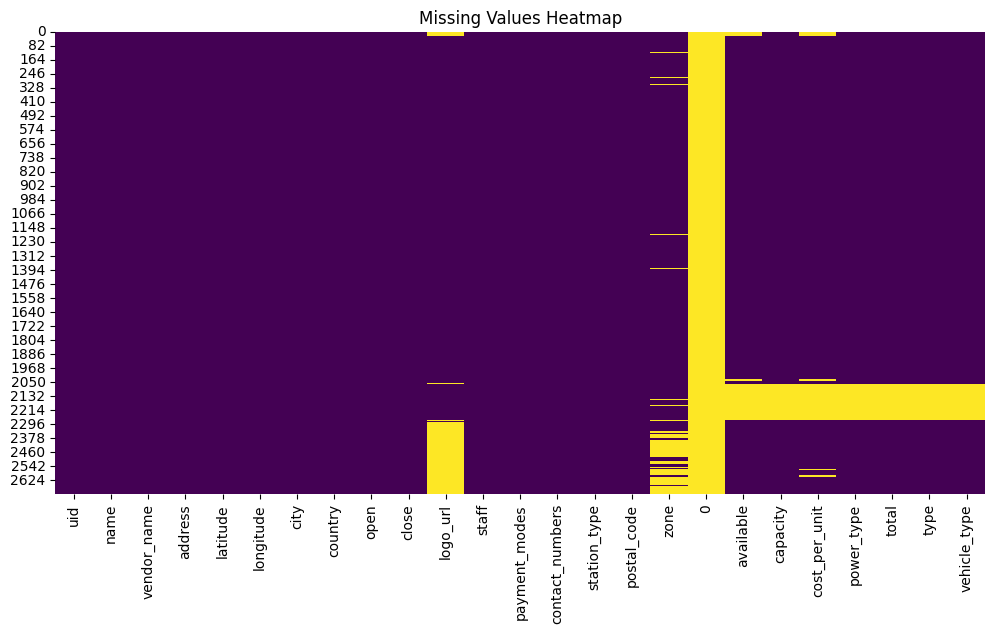

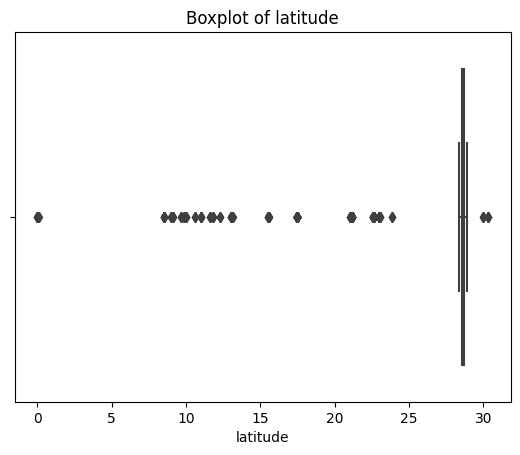

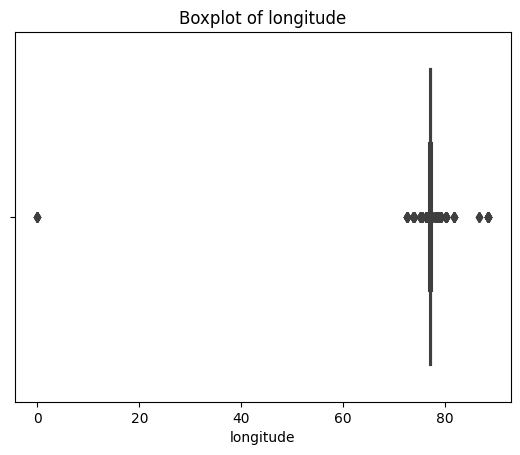

In [63]:
# Overview
print(data.info())
print(data.describe())
print(data.isnull().sum())

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Boxplots for numerical features
numerical_features = ['latitude', 'longitude']  # Add more numerical columns as needed
for feature in numerical_features:
    sns.boxplot(data=data, x=feature)
    plt.title(f"Boxplot of {feature}")
    plt.show()


# Preprocessing

In [64]:
data.drop(columns=[0], inplace=True)

In [65]:
# Example for missing value imputation
data['zone'].fillna('Unknown', inplace=True)
data['available'].fillna(data['available'].median(), inplace=True)
data['capacity'].fillna(data['capacity'].mode()[0], inplace=True)


In [66]:
# Identify and remove extreme outliers in 'available'
upper_limit = data['available'].quantile(0.99)
data = data[data['available'] <= upper_limit]


In [67]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['vendor_name', 'station_type', 'zone']
encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = encoder.fit_transform(data[col])


In [68]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['latitude', 'longitude', 'available', 'total']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


In [69]:
# Define the list of columns where NaN values need to be replaced
features = ['latitude', 'longitude',  'available', 'total']

# Replace NaN values with -1 in the specified columns
data[features] = data[features].fillna(-1)

# Verify the changes
print(data[features].isnull().sum())  # This should print zeros for all specified columns


latitude     0
longitude    0
available    0
total        0
dtype: int64


##### Replacing NaN Values with -1

In [70]:
# Step 1: Remove currency symbols and additional text
data['cost_per_unit'] = data['cost_per_unit'].replace(
    to_replace=r'₹(\d+)\s*per\s*unit', 
    value=r'\1', 
    regex=True
)

# Step 2: Convert to float
data['cost_per_unit'] = pd.to_numeric(data['cost_per_unit'], errors='coerce')

# Step 3: Replace NaN values with -1
data['cost_per_unit'].fillna(-1, inplace=True)

# Verify the changes
print(data['cost_per_unit'].head())


0   -1.0
1   -1.0
2   -1.0
3   -1.0
4   -1.0
Name: cost_per_unit, dtype: float64


In [71]:
# Step 1: Ensure the columns are numeric, coercing errors to NaN
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Step 2: Replace NaN values with -1 in the specified columns
data[features] = data[features].fillna(-1)

# Verify the changes
print(data[features].dtypes)  # Check data types
print(data[features].isnull().sum())  # Confirm no NaN values remain


latitude     float64
longitude    float64
available    float64
total        float64
dtype: object
latitude     0
longitude    0
available    0
total        0
dtype: int64


## Classification

In [72]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [73]:
# Select relevant features
features = ['latitude', 'longitude', 'cost_per_unit', 'available', 'total']
data_features = data[features]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)


### K-Mean Clustering:
K-Means Clustering is an unsupervised machine learning algorithm used to group data into a predefined number of clusters (k). It works by iteratively assigning data points to the nearest cluster center and updating the cluster centers as the mean of the assigned points. The algorithm minimizes the within-cluster variance, ensuring that points within a cluster are similar, while points in different clusters are distinct. K-Means is widely used for tasks like customer segmentation, image compression, and pattern recognition due to its simplicity and efficiency. However, it can be sensitive to the initial placement of cluster centers and is best suited for data with well-separated clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


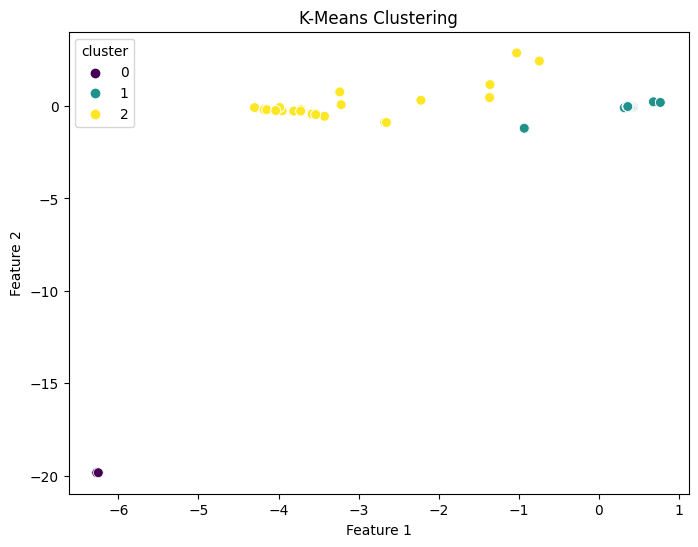

In [74]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
data['cluster'] = kmeans.fit_predict(data_scaled)

# Visualize clusters (optional)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data_scaled[:, 0], y=data_scaled[:, 1], 
    hue=data['cluster'], palette='viridis', s=50
)
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


### Isolation Forest
Isolation Forest is an anomaly detection algorithm designed to identify outliers by isolating data points. It builds multiple random trees (called Isolation Trees) by recursively splitting data points based on randomly chosen features and split values. Outliers are isolated more quickly, requiring fewer splits, resulting in shorter path lengths. The anomaly score is calculated based on these path lengths, where shorter paths indicate potential anomalies. Isolation Forest is highly efficient for high-dimensional datasets, unsupervised, and scalable, making it ideal for applications like fraud detection, network intrusion detection, and sensor data analysis.


Number of anomalies detected: 135


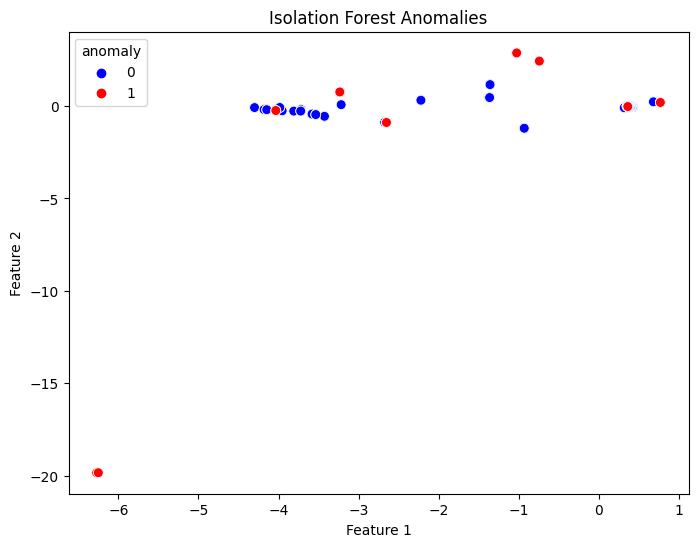

In [75]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)  # Adjust contamination
data['anomaly'] = iso_forest.fit_predict(data_scaled)

# Map anomaly labels (-1 for anomaly, 1 for normal)
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})

# Count anomalies
print(f"Number of anomalies detected: {data['anomaly'].sum()}")

# Visualize anomalies (optional)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data_scaled[:, 0], y=data_scaled[:, 1], 
    hue=data['anomaly'], palette={0: 'blue', 1: 'red'}, s=50
)
plt.title("Isolation Forest Anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


#### Listing the anamaly stations

In [82]:
# Filter anomalies
anomalies = data[data['anomaly'] == 1]

# Print the specified columns
print(anomalies[['uid', 'name', 'address', 'latitude', 'longitude', 'cost_per_unit', 'available', 'total']])


           uid                 name  \
5     STATIC18              Smart E   
6     STATIC19                  EEE   
7     STATIC19                  EEE   
8     STATIC20             BluSmart   
9     STATIC20             BluSmart   
...        ...                  ...   
2699      1028  EESL Nehru Park Met   
2701      1028  EESL Nehru Park Met   
2702      1028  EESL Nehru Park Met   
2703    BSES-1             BSES-DEL   
2704    BSES-1             BSES-DEL   

                                                address  latitude  longitude  \
5                        Uttam Nagar East metro station  0.374838  -0.056007   
6               Mukteshwar dham Andheriya bagh,mehrauli  0.347806  -0.028884   
7               Mukteshwar dham Andheriya bagh,mehrauli  0.347806  -0.028884   
8     Plot No. 24, Behind Fun & Food Village, Kapash...  0.350637  -0.050037   
9     Plot No. 24, Behind Fun & Food Village, Kapash...  0.350637  -0.050037   
...                                                

## Result and Silhouette Score
**Anomaly Detection Rate** refers to the percentage of data points identified as anomalies by an algorithm. It provides an overview of the proportion of outliers within a dataset. A high anomaly detection rate might indicate significant deviations or potential issues in the data, whereas a low rate suggests a more homogeneous dataset.

**Silhouette Score** measures the quality of clustering by evaluating how well each data point fits within its assigned cluster compared to other clusters. It ranges from -1 to 1, where a higher score indicates well-separated and cohesive clusters. A score close to 1 means the data points are well-matched to their clusters and distinct from others, while a negative score suggests incorrect clustering. Together, these metrics help assess the effectiveness of anomaly detection and clustering algorithms.

In [80]:
# Assuming you already have your Isolation Forest model
# Replace `isolation_forest_model` with your trained model
predicted_anomalies = iso_forest.predict(data[features])

# In Isolation Forest, -1 indicates an anomaly, 1 indicates normal
anomaly_rate = (predicted_anomalies == -1).sum() / len(predicted_anomalies) * 100
print(f"Anomaly Detection Rate: {anomaly_rate:.2f}%")


Anomaly Detection Rate: 6.55%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [81]:
from sklearn.metrics import silhouette_score

# Assuming you already have your K-Means model and predicted labels
# Replace `kmeans_model` with your trained K-Means model
predicted_labels = kmeans.predict(data[features])

# Calculate the silhouette score (higher is better)
sil_score = silhouette_score(data[features], predicted_labels)
print(f"Silhouette Score for K-Means: {sil_score}")


Silhouette Score for K-Means: 0.4902012569562338


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


### Observations from the Metrics:

1. **Silhouette Score (0.49):**
   - The score indicates moderate clustering quality. It suggests that while the clusters are somewhat cohesive and distinct, there is room for improvement.
   - A score closer to 1 would imply better-defined clusters. This score implies some overlap or less distinct separation between clusters in the dataset.

2. **Anomaly Detection Rate (6.55%):**
   - The anomaly detection rate indicates that a small proportion of the dataset is identified as anomalies (approximately 6.55%).
   - This rate seems reasonable for fraud detection or outlier analysis, suggesting the dataset has a few significant deviations, which might be genuine anomalies.

### Recommendations:
- **Improve Feature Scaling:** Normalize or standardize features to improve clustering and separation.
- **Optimize `k` for K-Means:** Experiment with different values of `k` using the elbow method or silhouette analysis to find the optimal number of clusters.
- **Enhance Feature Engineering:** Derive meaningful features, such as geographic zones, time-based patterns, or statistical aggregates, to improve clustering quality.
- **Parameter Tuning for Isolation Forest:** Adjust the contamination parameter or explore ensemble approaches to refine anomaly detection.

